***Paradise News:***

https://www.paradisepost.com/tag/camp-fire/ 

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp 
import seaborn as sns
%matplotlib inline
import lxml.html as lx
import requests
import requests_cache
import nltk
import nltk.corpus
import time
import re
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS
requests_cache.install_cache("my_cache_paradise")

In [2]:
def total_articles(url): 
    response = requests.get(url)
    time.sleep(1)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    html.make_links_absolute(url)
    dup_links = html.xpath("//h4/a/@href")
    links = list(set(dup_links))
    return links

In [3]:
#total_articles("https://www.paradisepost.com/tag/camp-fire/") ##10 most current articles 

In [4]:
#accounting for multiple pages
def mult_pages(url, page): 
    """takes in url as a string and number of pages wanting to read through (each page will give 10 articles)"""
    empty = []
    for i in list(range(0,page)):
        current_iterate = total_articles("https://www.paradisepost.com/tag/camp-fire/" + ("page" + str(i)))
        empty = empty + current_iterate
    return empty 

In [5]:
mult_pages("https://www.paradisepost.com/tag/camp-fire/", 1) ##10 most current articles 

['https://www.paradisepost.com/2019/02/27/symphony-orchestra-will-host-concerts-honoring-first-responders-teachers/',
 'https://www.paradisepost.com/2019/02/27/pge-delayed-repairs-for-years-on-transmission-line-linked-to-lethal-camp-fire/',
 'https://www.paradisepost.com/2019/03/01/lime-saddle-campground-in-oroville-opened-exclusively-to-camp-fire-survivors/',
 'https://www.paradisepost.com/2019/02/28/local-4-h-members-help-paradise-youth-rebuild/',
 'https://www.paradisepost.com/2019/03/01/county-accepting-applications-for-alternative-debris-removal-program-until-march-15/',
 'https://www.paradisepost.com/2019/02/28/pge-equipment-likely-to-be-blamed-for-starting-lethal-camp-fire-utility-says/',
 'https://www.paradisepost.com/2019/02/27/town-says-burn-permits-available-for-purchase-starting-tomorrow/',
 'https://www.paradisepost.com/2019/03/01/help-needed-to-learn-more-about-three-victims/',
 'https://www.paradisepost.com/2019/02/26/north-valley-community-foundation-releases-100000-mor

In [6]:
#take out related articles. receive the text 
def single_article(url): 
    response = requests.get(url)
    time.sleep(1)
    html = lx.fromstring(response.text)
   
    #text
    text = html.xpath("//div[contains(@class, 'article-body')]/div[contains(@class, 'body-copy')]/p/text()[not(descendant::em)] | ///div[contains(@class, 'article-body')]/div[contains(@class, 'body-copy')]//ul/li/text()")
    text = ' '.join(text)
    
    #dates
    dates = html.xpath("///div[contains(@class, 'time')]//time/@datetime")[0]
    #first date is published, second date is updated 
    
    return {"url": url, "text": text, "dates": dates}

In [7]:
single_article("https://www.paradisepost.com/2019/02/26/north-valley-community-foundation-releases-100000-more-in-grants-for-camp-fire-relief/")

{'url': 'https://www.paradisepost.com/2019/02/26/north-valley-community-foundation-releases-100000-more-in-grants-for-camp-fire-relief/',
 'text': 'CHICO — The North Valley Community Foundation announced on Monday it was releasing $100,000 more in grants to local schools and other groups providing relief to people affected by the Camp Fire. This brings the total amount of the foundation’s Camp Fire Relief Fund grants awarded to $2,516,903. This week’s grants went to: Paradise Unified School District ($25,000): To help provide adequate internet access at the Paradise Intermediate School, currently convening in the old Orchard Hardware Store building in Chico. The district requested a grant to help pay for discounted data costs. T-Mobile has donated a cell tower and hotspots, according to the North Valley Community Foundation. Magalia Pines Baptist Church ($25,000): To help the Magalia Pines Recovery Center continue its relief operations, including: “food service, water, utility assistan

In [8]:
def all_articles(url, page): 
    listing_numb = []
    all_pages = mult_pages(url, page)
    for i in list(range(0, len(all_pages))):
        listing_numb = listing_numb + [single_article(all_pages[i])]
    return pd.DataFrame(listing_numb)

In [9]:
one_month = all_articles("https://www.paradisepost.com/tag/camp-fire/", 8)
#one_month #camp fire articles in the past month for paradise website 

##takes roughly 2 minutes

In [10]:
one_month["dates"] = pd.to_datetime(one_month["dates"])
date_sort = one_month.sort_values(by = "dates")
#date_sort #sorted by date

In [11]:
date_sort.to_pickle("paradise_articles.txt")

In [12]:
nltk.download("gutenberg")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package gutenberg to /Users/Troy/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Troy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Troy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Troy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Troy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
def all_text(dataframe):
    """takes in dataframe and outputs all text columns into one string"""
    init_frame = ""
    for i in list(range(0,len(dataframe))):
        init_frame = init_frame + dataframe["text"][i]
    return init_frame

In [14]:
def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

In [52]:
def token_plot(dataframe):
    """takes dataframe and desired subset (should be a string). outputs tokenized plot of text"""
    #tokenize
    corpus = all_text(dataframe)
    biz_token = nltk.word_tokenize(corpus)
    #resetting index to make sure all_text works 

    #lower case
    biz_token[:10]
    lower = [w.lower() for w in biz_token]
    lower[:10]

    #lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    tags = nltk.pos_tag(lower)
    lemm = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in tags]
    lemm

    #stopwords
    stopwords = nltk.corpus.stopwords.words("english") + ["pg", "e", "would", "make", "also", "could", "get", "go", "come", "time", "day", "know", "take", "first", "include"]
    full = [w for w in lemm if w not in stopwords]
    
    #plotting
    fq = nltk.FreqDist(w for w in full if w.isalnum())
    return fq.plot(20, title = "Top 25 Word Frequencies: Local", cumulative = False)

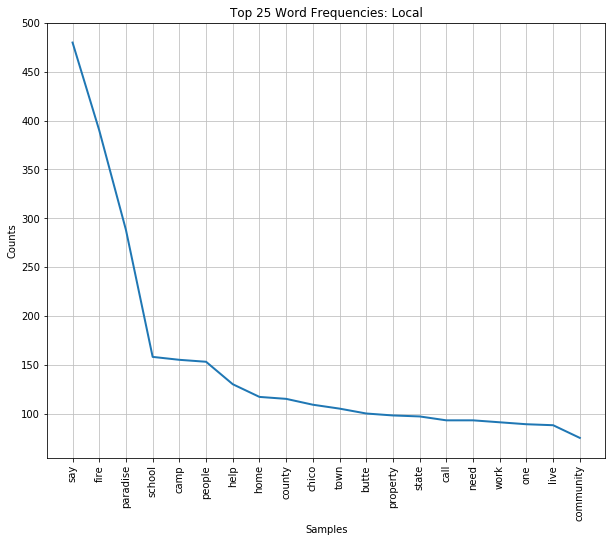

In [53]:
token_plot(date_sort)

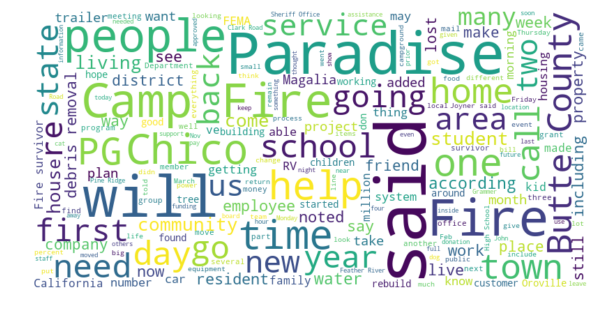

In [54]:
plt.rcParams["figure.figsize"] = [10, 8]
doc = ' '.join(date_sort['text'].tolist())
wordcloud = WordCloud(width = 800,
                     height = 400,
                     max_font_size = 100,
                     background_color = "white").generate(doc)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [17]:
def tokenize_lemm(dataframe):
    """takes dataframe and desired subset (should be a string). outputs tokenized plot of text"""
    #tokenize
    corpus = all_text(dataframe)
    biz_token = nltk.word_tokenize(corpus)
    #resetting index to make sure all_text works 

    #lower case
    biz_token[:10]
    lower = [w.lower() for w in biz_token]
    lower[:10]

    #lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    tags = nltk.pos_tag(lower)
    lemm = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in tags]

    #stopwords
    stopwords = nltk.corpus.stopwords.words("english") + ["say", "pg", "e", "would", "make", "also", "could", "get", "go"]
    full = [w for w in lemm if w not in stopwords]
    
    return full

## not to be used 

In [18]:
token_lemm = tokenize_lemm(date_sort)

## not to be used

In [19]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [20]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [28]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
text_list = date_sort["text"].tolist()
vec = TfidfVectorizer(min_df = 0.05, tokenizer = tokenize_and_stem, 
                      stop_words = "english", 
                      sublinear_tf = True)
tfidf = vec.fit_transform(text_list)

In [29]:
text_list

['PARADISE — Emotions and tempers ran high Monday morning as the Paradise Town Council held an open, emergency meeting before voting on a new ordinance that would make it illegal for Camp Fire survivors to live in recreational vehicles on property with burned debris. The decision comes a little more than a week after the town council and the Butte County Board of Supervisors were informed that the previously-passed ordinances that allowed residents to live in RVs more than 100 feet from debris could jeopardize the $1.7 billion in Federal Emergency Management Agency funding earmarked for debris removal. The new urgency ordinance, No. 575, replaces Urgency Ordinance No. 573, and changes who is allowed to be on property with burned debris before removal and when. Under Ordinance No. 573 passed in December, residents living in temporary housing — RVs and trailers — with a qualifying destroyed structure for debris removal would be able to live on the property up until the time of clean up, 

In [30]:
tfidf

<80x1042 sparse matrix of type '<class 'numpy.float64'>'
	with 8845 stored elements in Compressed Sparse Row format>

In [31]:
terms = vec.get_feature_names()
terms[:5]

['a.m.', 'able', 'accepting', 'according', 'activity']

In [65]:
#tfidf bigram
vec_bigram = TfidfVectorizer(min_df = 0.075,
                             max_df = 0.8,
                             tokenizer = tokenize_and_stem,
                             stop_words = "english",
                             sublinear_tf = True,
                             ngram_range=(2,2))
tfidf = vec_bigram.fit_transform(text_list)

In [66]:
terms_bigram = vec_bigram.get_feature_names()
terms_bigram

['a.m. p.m.',
 'affected camp',
 'alternative debris',
 'butte county',
 'butte strong',
 'cal oes',
 'camp survivors',
 'clark road',
 'company s',
 'county sheriff',
 'debris removal',
 'destructive wildfire',
 'didn t',
 'doesn t',
 'don t',
 'e s',
 'elementary school',
 'gavin newsom',
 'gerald rodrigues',
 'going come',
 'high school',
 'impacted camp',
 'intermediate school',
 'isn t',
 'little bit',
 'lost home',
 'lot people',
 'make sure',
 'mobile home',
 'north valley',
 'paradise high',
 'paradise intermediate',
 'paradise town',
 'paradise unified',
 'pg e',
 'pine ridge',
 'press release',
 'property owners',
 'removal program',
 'ridge school',
 's good',
 's office',
 'said don',
 'said people',
 'said s',
 'san bruno',
 'school district',
 'school paradise',
 'school students',
 'sheriff s',
 'state s',
 'strong fund',
 't know',
 't want',
 'town paradise',
 'unified school',
 'wasn t',
 'won t']